In [96]:
import cv2
# import autograd.numpy as np
# from autograd import grad
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicg
from scipy.sparse.linalg import gmres

from scipy.optimize import fmin_cg
from scipy.optimize import minimize
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm
import sklearn
import sklearn.neighbors as neighbors

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
import numpy as np
from scipy.sparse.linalg import bicg, bicgstab
from scipy.signal import convolve2d

# from sklearn.neighbors import LSHForest

In [97]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

In [98]:
def downscale(x, alpha, show=False):
    '''
     @input x: blurred img x
     @input alpha: scaling factor 

     @return: downscaled image (x/alpha)
    '''
    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

In [99]:
def bkMat(K_mag, K_dir, patch_size=31):
    
    import time
    st = time.time()
    rows, cols = K_mag.shape
    out = np.zeros((patch_size*patch_size, rows*cols))
    index = 0
    for r in range(rows):
        for c in range(cols):
            print(r,c, end='\r')
            kernel = utils.blurKernel(int(K_mag[r,c]), K_dir[r,c])
            pd = patch_size - kernel.shape[0]
            kernel = np.pad(kernel, ((pd//2, pd-pd//2), (pd//2, pd-pd//2)), 'constant', constant_values=(0, 0))
            out[:,index] = kernel.ravel()
            index += 1
    en = time.time()
    print(en-st)
    return out

image ./resources/blurcheetah.jpg loaded
21.980555111355933
(321, 481)


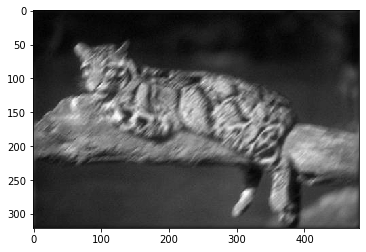

In [100]:
img = downscale(utils.loadImage('./resources/blurcheetah.jpg', 'gray'), 1)/255
noise, noised_img = pinkNoise.addNoise(img*255, exponent = -1)
# magnitude, directions = reblur.getImageBlurEstimate(noised_img, 7)
# K_mat = bkMat(magnitude, directions, 7)
# K_matrot = bkMat(magnitude, directions+180, 7)
# K_mat = bkMat(7*np.ones(img.shape), 45*np.ones(img.shape), 7)
# K_matrot = K_mat
x = img
print(x.shape)
plt.imshow(x, cmap='gray')


In [101]:
from annoy import AnnoyIndex

class AnnoyKNN:
    def __init__(self, patch_size, method):
        self.patch_size = patch_size
        self.feature_dims = patch_size*patch_size
        self.KNN = AnnoyIndex(self.feature_dims, method)

    
    def make_index(self, img):
        """
            make indices to be used for search in KNN
            patches are flatten and treated as 1D vectors
        """
        img = utils.im2col(img, [self.patch_size, self.patch_size])
        for i in range(img.shape[1]):
            self.KNN.add_item(i, (img.T)[i,:])
            
    def build(self, n_trees):
        """
            specify the no. of trees to be used
            more trees -> higher accuracy, higher search time
        """
        self.KNN.build(n_trees)
        
    def get_nn(self, patch):
        """
            input patch to be searched
            returns the nearest patch from indices
        """
        nn = self.KNN.get_nns_by_vector(patch.flatten(), 1)
#         print(nn)
        nn = self.KNN.get_item_vector(nn[0])
        return (np.array(nn)).reshape((self.patch_size, self.patch_size))

In [202]:
"""
imrpove -> predict for the entire row at once, using njobs
intra image reccurence
"""

from annoy import AnnoyIndex
import random
import time

def getPrior(img, patch_size, alpha, h, stride):
    """
    @input img: size (n x m)
    @input patch_size
    @input alpha
    @input h
    @input stride: not used
    
    @return z: size (n x m)
    """
    
    start = time.time()
    M = patch_size
    x_alpha = downscale(img, alpha)
    n,m = img.shape
    
    KNN = AnnoyKNN(M, 'euclidean')
    KNN.make_index(x_alpha)
    KNN.make_index(img)
    KNN.build(10)

    z = np.zeros(img.shape)
    
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += KNN.get_nn(img[i-M//2:i+M//2+1, j-M//2:j+M//2+1])/(M*M)
    
    end = time.time()
    print('time taken:', end-start)
    
    return z

In [161]:
z = getPrior(x, 15, 4/3, 10, 1)

/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



time taken: 12.304430723190308


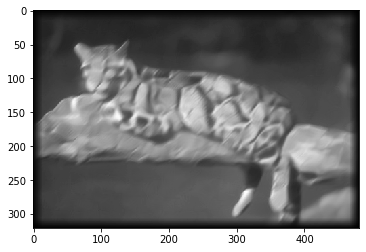

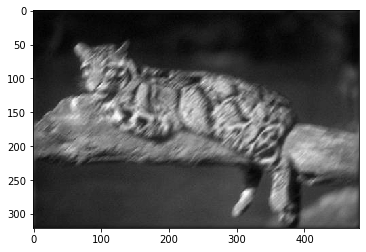

In [162]:
plt.imshow(z, cmap='gray')
plt.show()
plt.imshow(x, cmap='gray')

In [163]:
# K_mat = bkMat(magnitude, directions)
# K_matrot = bkMat(magnitude, directions+180)
K_mat = bkMat(7*np.ones(img.shape), 45*np.ones(img.shape), 7)
# print(K_mat.shape)
# K_mat = 10*K_mat/7
K_matrot = K_mat

56.965654850006176 402 480 245 198 391 124 159 222 244 235 450 142 462 120 358 4


In [264]:
ss = img.shape
b = np.ones(ss).ravel()
beta = 50

itera = 1
noiseSD = 0.01
patchSize = 7
alpha = 4/3
betas = 49*np.array([1])
T = 10
h = 10
stride = 1
K=cv2.getGaussianKernel(5,1)
K = K@K.T
lam = 1/(noiseSD**2)
noiseI = np.float32(x)
lambda2 = 49

def call_func(x):
#     global ss, K, b, magnitude, directions
#     img = x.reshape(ss)
#     outp = myConvolve(img, K_mat, patch_size=7)
#     outp = myConvolve(outp, K_matrot, patch_size=7)

#     cost = np.mean(np.power(outp.ravel() - b, 2))
    global itera

    print("      Iter ->     ", itera, ' cost -- > ', 0)
    itera += 1

# def myConvolve(img, K_mag, K_dir, patch_size=30):
#     outp = np.zeros(img.shape)
#     pd = patch_size // 2
#     img = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    
#     for i in range(pd, img.shape[0]-pd):
#         for j in range(pd, img.shape[1]-pd):
#             kernel = utils.blurKernel(int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])
#             kx, ky = kernel.shape
#             kernel=kernel.ravel()[:,None]
            
#             patch = img[i-kx//2:i+kx//2, j-ky//2:j+ky//2].ravel()[:,None]
#             o = np.sum(patch * kernel)
# #             o = utils.linearBlur(img[:i+pd,j-pd:j+pd], int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])[15,15]
#             outp[i-pd,j-pd] = o
            
#     return outp
    
def myConvolve(img, kernel_matrix, patch_size=7):
    outp = np.zeros(img.shape)
    
    pd = patch_size // 2
    img_shape = img.shape
    pimg = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    col_img = utils.im2col(pimg, [patch_size, patch_size])
    outp = np.sum(col_img * kernel_matrix, axis = 0)
    
  
    
    return outp.reshape(img_shape)
 
def myConvolveLaplacian(img, patch_size = 7):
    pd = 1
    pimg = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    col_img = utils.im2col(pimg, [3,3])
    laplac = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]]).ravel()
    oimg = np.sum(col_img*laplac[:,None], axis=0)
    return oimg

def myConvolveGamma(img, gamma=0.5):
    pd = 1
    pimg = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    col_img = utils.im2col(pimg, [3,3])
#     col_img = np.power(col_img, -1)
#     laplac = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]]).ravel()
    oimg = col_img - col_img[4,:]
    oimg = np.power(oimg, gamma-1)
    oimg = np.sum(np.abs(col_img), axis=0)
    return oimg

def make_mv(x):
    def mv(x):
        img = x.reshape(ss)
#         plt.imshow(img, cmap = 'gray')
#         plt.show()
        outp = myConvolve(img, K_mat, patch_size=7)
#         oimg = myConvolveLaplacian(img, patch_size=7)
    

#         K_dir = K_dir + 180

        foutp = myConvolve(outp, K_matrot, patch_size=7)
#         foimg = myConvolveLaplacian(oimg.reshape(ss), patch_size=7)
#         foimg = myConvolveLaplacian(foimg.reshape(ss), patch_size=7)
        goimg = myConvolveGamma(img)
        
#         print("asdasd", np.max(goimg))
        return lam*foutp.ravel() + 49*beta*x + 0.005*lam*goimg
    return mv


func = make_mv(x)
A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=func, rmatvec=func)

/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in power


In [265]:
np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

In [266]:
# plt.imshow(, cmap = 'gray')
# plt.show()
# plt.imshow(, cmap = 'gray')
# plt.show()
print(np.sum(myConvolve(img, K_mat)-myConvolve(img, K_matrot)))

0.0


In [267]:
from scipy.optimize import fmin_bfgs

def EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, T, alpha, h, stride):
    global z, x, A, beta, itera
#     beta = np.abs(betas[0]/4)
    cleanI = noiseI
    for betaa in betas:
        beta = betaa
        for tt in range(T):
            
            print("Iteration -> ", tt)
#             I1 = img
            tt1 = cleanI
            I1 = getPrior(cleanI, 15, alpha, h, stride)
#             tt1 = noiseI[(K.shape[0]//2):-(K.shape[0]//2),(K.shape[1]//2):-(K.shape[1]//2)]
#             tt1 = convolve2d(tt1, np.rot90(np.rot90(K)), 'full')
            tt1 = myConvolve(tt1, K_matrot)
            tt2 = I1
            x0 = I1.ravel()
            maxval = np.max(lam*tt1.ravel() + beta*tt2.ravel()) 
            print(np.max(lam*tt1.ravel() + beta*tt2.ravel()))
            cleanI = gmres(A, lam*tt1.ravel() + 49*beta*tt2.ravel(), callback=call_func, maxiter=1000)
            
#             cleanI = bicgstab(A, lam*tt1.ravel() + beta*tt2.ravel(), x0 = x0, callback=call_func, maxiter=100)
            cleanI = np.reshape(cleanI[0], noiseI.shape)
            arr = plt.subplots(1,2, figsize = (30,30))[1]
#             arr[0].imshow(z, cmap='gray')
            arr[0].imshow(I1, cmap='gray')
            arr[1].imshow(cleanI, cmap='gray')
            
#             print(np.sum(cleanI-z), np.sum(z), np.sum(cleanI[30:-30,30:-30]-x[30:-30,30:-30]))
    return cleanI

Iteration ->  0


/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



time taken: 17.071458101272583
10497.110468596553


/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in power
/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in power


      Iter ->      1  cost -- >  0
      Iter ->      2  cost -- >  0
      Iter ->      3  cost -- >  0
      Iter ->      4  cost -- >  0
      Iter ->      5  cost -- >  0
      Iter ->      6  cost -- >  0
      Iter ->      7  cost -- >  0
      Iter ->      8  cost -- >  0
      Iter ->      9  cost -- >  0
      Iter ->      10  cost -- >  0
      Iter ->      11  cost -- >  0
      Iter ->      12  cost -- >  0
      Iter ->      13  cost -- >  0
      Iter ->      14  cost -- >  0
      Iter ->      15  cost -- >  0
      Iter ->      16  cost -- >  0
      Iter ->      17  cost -- >  0
      Iter ->      18  cost -- >  0
      Iter ->      19  cost -- >  0
      Iter ->      20  cost -- >  0
      Iter ->      21  cost -- >  0
      Iter ->      22  cost -- >  0
      Iter ->      23  cost -- >  0
      Iter ->      24  cost -- >  0
      Iter ->      25  cost -- >  0
      Iter ->      26  cost -- >  0
      Iter ->      27  cost -- >  0
      Iter ->      28  cost -- >  0
 


time taken: 18.37691569328308
9348.96955705129
      Iter ->      37  cost -- >  0
      Iter ->      38  cost -- >  0
      Iter ->      39  cost -- >  0
      Iter ->      40  cost -- >  0
      Iter ->      41  cost -- >  0
      Iter ->      42  cost -- >  0
      Iter ->      43  cost -- >  0
      Iter ->      44  cost -- >  0
      Iter ->      45  cost -- >  0
      Iter ->      46  cost -- >  0
      Iter ->      47  cost -- >  0
      Iter ->      48  cost -- >  0
      Iter ->      49  cost -- >  0
      Iter ->      50  cost -- >  0
      Iter ->      51  cost -- >  0
      Iter ->      52  cost -- >  0
      Iter ->      53  cost -- >  0
      Iter ->      54  cost -- >  0
      Iter ->      55  cost -- >  0
      Iter ->      56  cost -- >  0
      Iter ->      57  cost -- >  0
      Iter ->      58  cost -- >  0
      Iter ->      59  cost -- >  0
      Iter ->      60  cost -- >  0
      Iter ->      61  cost -- >  0
      Iter ->      62  cost -- >  0
      Iter ->   


time taken: 17.821826457977295
8439.545126710429
      Iter ->      96  cost -- >  0
      Iter ->      97  cost -- >  0
      Iter ->      98  cost -- >  0
      Iter ->      99  cost -- >  0
      Iter ->      100  cost -- >  0
      Iter ->      101  cost -- >  0
      Iter ->      102  cost -- >  0
      Iter ->      103  cost -- >  0
      Iter ->      104  cost -- >  0
      Iter ->      105  cost -- >  0
      Iter ->      106  cost -- >  0
      Iter ->      107  cost -- >  0
      Iter ->      108  cost -- >  0
      Iter ->      109  cost -- >  0
      Iter ->      110  cost -- >  0
      Iter ->      111  cost -- >  0
      Iter ->      112  cost -- >  0
      Iter ->      113  cost -- >  0
      Iter ->      114  cost -- >  0
      Iter ->      115  cost -- >  0
      Iter ->      116  cost -- >  0
      Iter ->      117  cost -- >  0
      Iter ->      118  cost -- >  0
      Iter ->      119  cost -- >  0
      Iter ->      120  cost -- >  0
      Iter ->      121  cost 

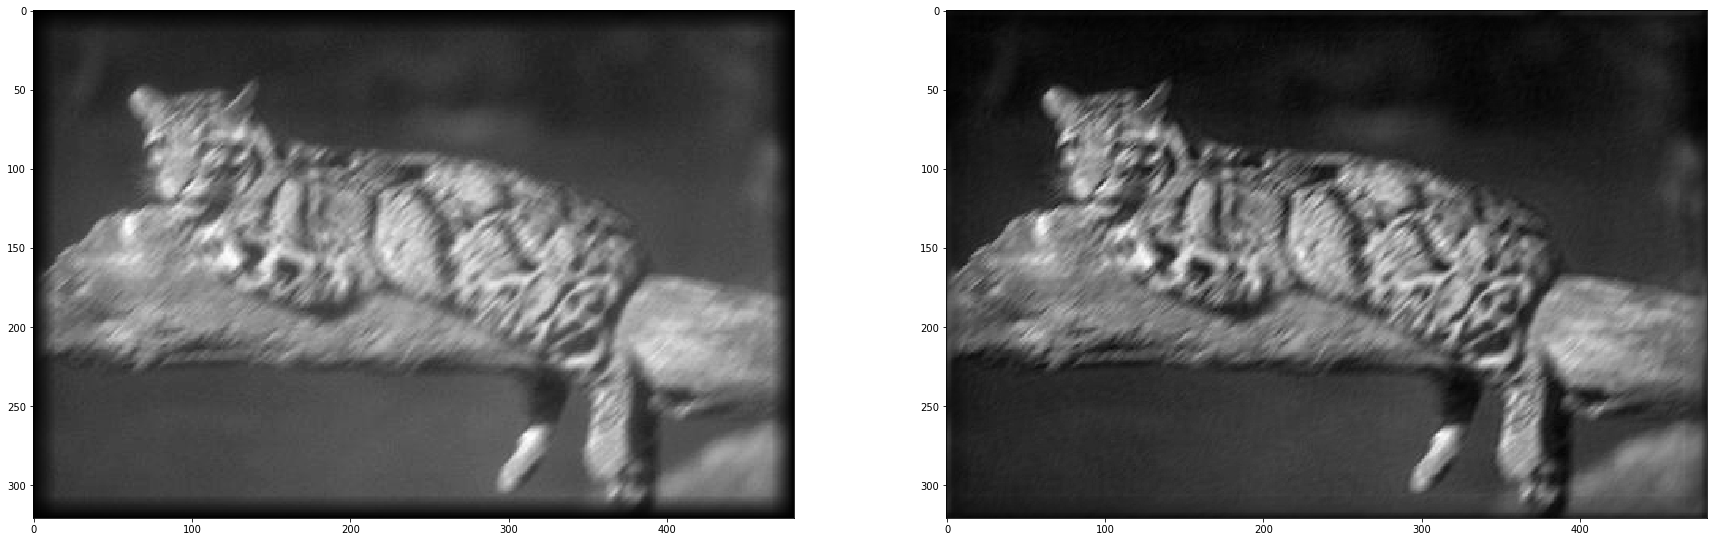

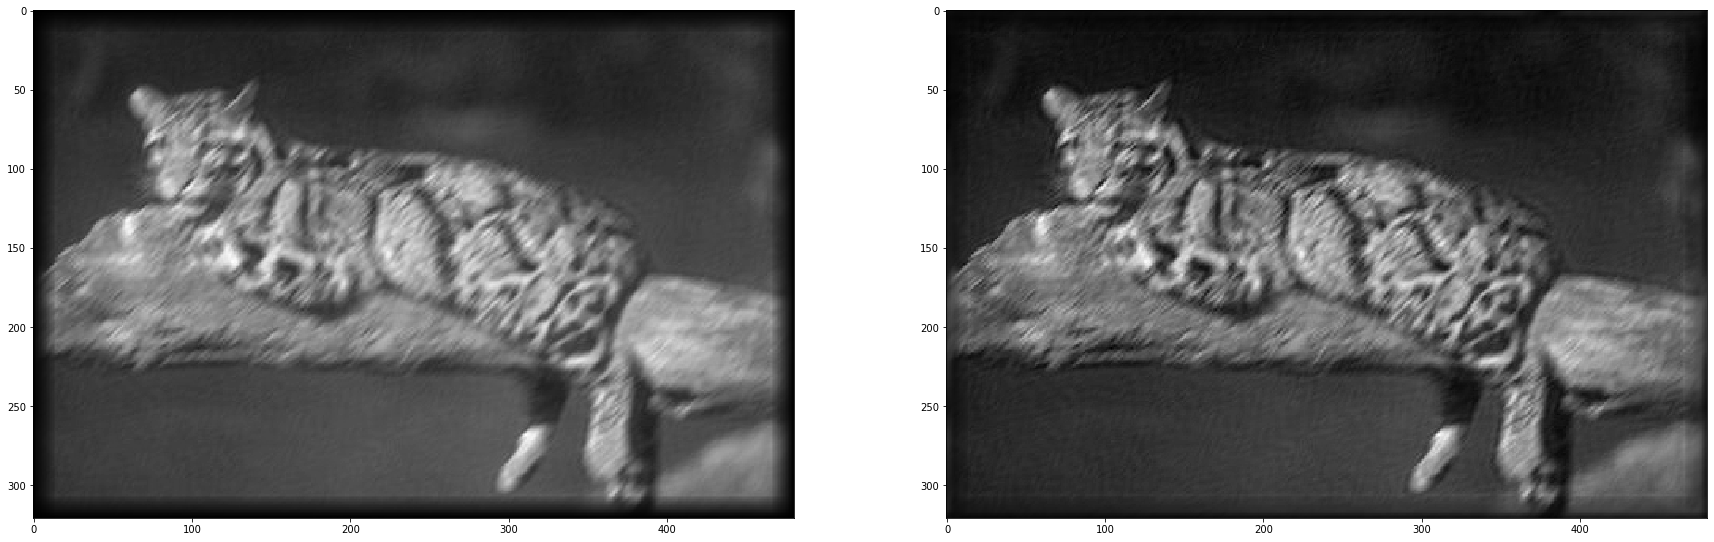

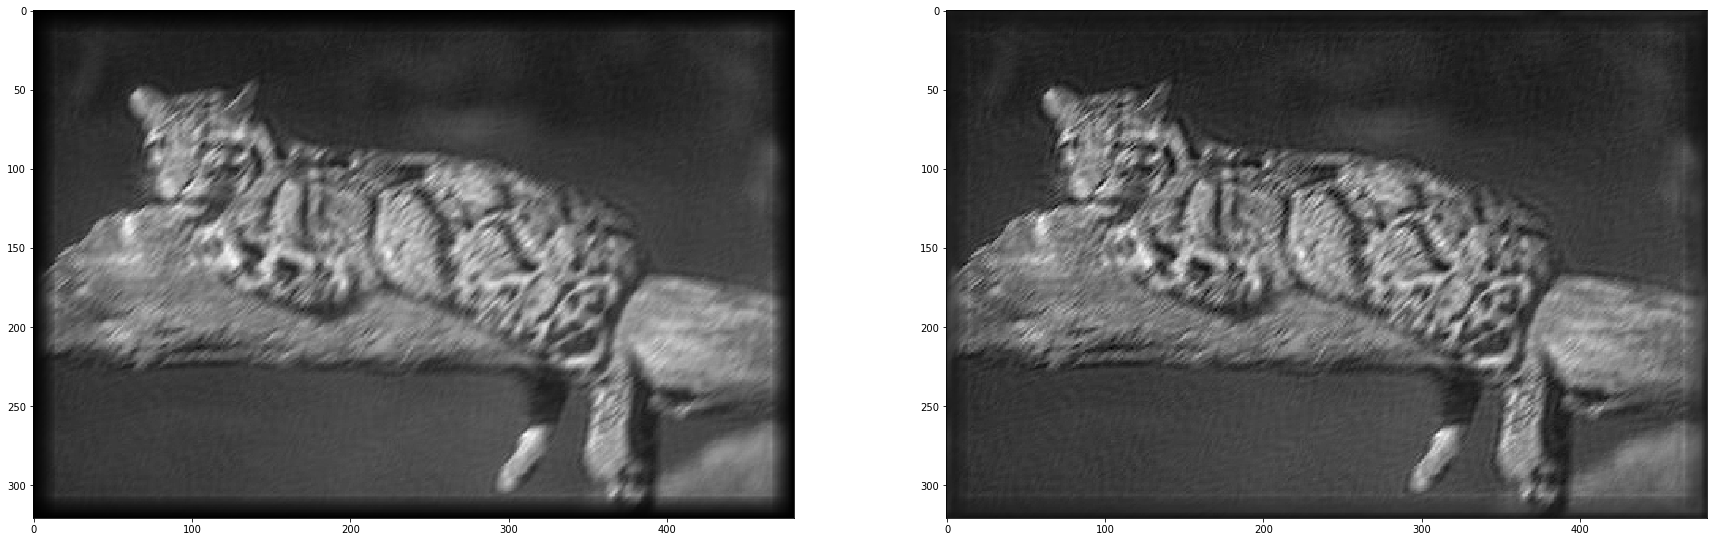

In [268]:

cleanI = EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, 3, alpha, h, stride)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


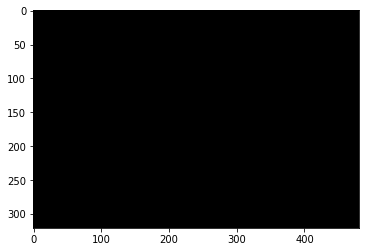

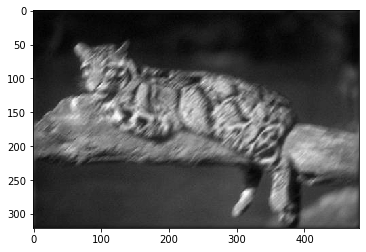

In [140]:
cleanI1 = np.where(cleanI<0, 0, cleanI)
cleanI2 = np.where(cleanI1>1, 1, cleanI1)
print(cleanI2)
plt.imshow(cleanI2, cmap='gray')
plt.show()
plt.imshow(img, cmap='gray')

In [17]:
K = [[2, 1], [1, 1]]
ss = (2, 2)
def mv(x):
    global K, ss
    img = x.reshape(ss)
    print(img)
    outp = convolve2d(img, K, 'same')
    outp = convolve2d(img, K, 'same')
    return outp.ravel()

A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=mv, rmatvec=mv)

x = convolve2d(inp, K, 'same')
x = convolve2d(x, K, 'same')
b = x.ravel()

bicg(A, b)

[[0. 0.]
 [0. 0.]]


NameError: name 'inp' is not defined

In [ ]:
# K=cv2.getGaussianKernel(5,1)
# K = K@K.T
# ss = img.shape
# itera = 1
# b = np.ones(ss).ravel()
# def call_func(x):
#     global ss, K, b
#     img = x.reshape(ss)
#     outp = convolve2d(img, K, 'same')
#     cost = np.mean(np.power(outp.ravel() - b, 2))
#     global itera
#     print("      Iter ->     ", itera, "cost->       ", cost)
#     itera += 1
    
# def mv(x):
#     global ss, K
#     img = x.reshape(ss)
#     outp = convolve2d(img, K, 'same')
#     return outp.ravel()

# A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=mv, rmatvec=mv)

# x0 = np.zeros(ss).ravel()

# # x = bicg(A, b, x0, callback=call_func, maxiter=100)

In [ ]:
def f(a,b):
    def g():
        print(a, b)
    return g
kk = f(1,2)

In [ ]:
outputt = bkMat(magnitude, directions, 31)
print(outputt.shape)

In [ ]:
print(np.round(10*outputt[:,11].reshape((11,11))), directions[0,11])
# print(np.round(utils.blurKernel(10,90)*10))


In [ ]:
o = myConvolve(x, magnitude, directions)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(o, cmap='gray')

In [ ]:
utils.im2col(np.pad(img, ((5, 5), (5, 5)), 'reflect'), [11, 11]).shape